In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
# from sodapy import Socrata

ModuleNotFoundError: No module named 'sodapy'

In [2]:
df = pd.read_pickle("../data/df.pickle")
df = df.dropna()

In [3]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_resi1 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-01")].dropna()
df_resi2 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-11-16")].dropna()
df_2020_nov = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-12-01")].dropna()
df_lockdown_relax = df[(df["started_at"] >= "2020-11-16") & (df["started_at"] < "2020-12-17")].dropna()
df_after_lockdown = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2023-10-01")].dropna()
df_aft_eto = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-02-23")].dropna()

# dfを2ヶ月ごとに分割
df_2020_4_5 = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] < "2020-06-01")].dropna()
df_2020_6_7 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-08-01")].dropna()
df_2020_8_9 = df[(df["started_at"] >= "2020-08-01") & (df["started_at"] < "2020-10-01")].dropna()
df_2020_10_11 = df[(df["started_at"] >= "2020-10-01") & (df["started_at"] < "2020-12-01")].dropna()
df_2020_12 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] < "2021-01-01")].dropna()

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [5]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [14]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        df_tmp['start_station_id'] = df_tmp['start_station_id'].astype(float)
        df_tmp['end_station_id'] = pd.to_numeric(df_tmp['end_station_id'], errors='coerce')

        station_df = df_tmp[['start_station_id', 'start_station_name']].drop_duplicates()
        station_df = station_df.set_index('start_station_id')

        # node_listにstation_dfの数を追加
        node_list.append(len(station_df))

        # edge_listにdf_tmpの数を追加
        edge_list.append(len(df_tmp))   
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list, timestamp

In [ ]:
def return_nm_string(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        df_tmp['start_station_id'] = df_tmp['start_station_id'].astype(str)
        df_tmp['end_station_id'] = pd.to_numeric(df_tmp['end_station_id'], errors='coerce')

        station_df = df_tmp[['start_station_id', 'start_station_name']].drop_duplicates()
        station_df = station_df.set_index('start_station_id')

        # node_listにstation_dfの数を追加
        node_list.append(len(station_df))

        # edge_listにdf_tmpの数を追加
        edge_list.append(len(df_tmp))   
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list, timestamp

In [7]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [8]:
alpha_list = [0.471, 0.352, 0.081, 0.447, 0.205, 0.115, 0.116]
beta_list = [9.707, 5.342, 0.819, 25.649, 4.351, 8.175, 7.791]
label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

In [13]:
# lockdown時のノード数とエッジ数を取得
node_lockdown, edge_lockdown, timestamp_lockdown = return_nm(df_lockdown)

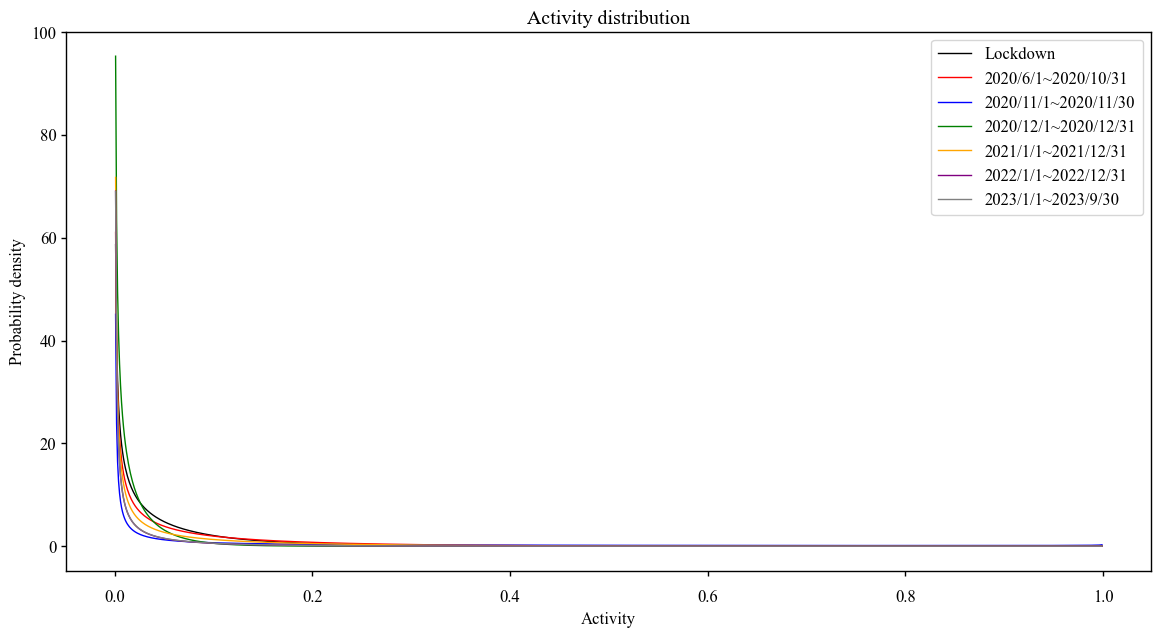

In [51]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(a, rho(a, alpha_list[0], beta_list[0]), label=label_list[0], color="black", linewidth=1)
plt.plot(a, rho(a, alpha_list[1], beta_list[1]), label=label_list[1], color="red", linewidth=1)
plt.plot(a, rho(a, alpha_list[2], beta_list[2]), label=label_list[2], color="blue", linewidth=1)
plt.plot(a, rho(a, alpha_list[3], beta_list[3]), label=label_list[3], color="green", linewidth=1)
plt.plot(a, rho(a, alpha_list[4], beta_list[4]), label=label_list[4], color="orange", linewidth=1)
plt.plot(a, rho(a, alpha_list[5], beta_list[5]), label=label_list[5], color="purple", linewidth=1)
plt.plot(a, rho(a, alpha_list[6], beta_list[6]), label=label_list[6], color="gray", linewidth=1)


plt.xlabel("Activity")
plt.ylabel("Probability density")
plt.title("Activity distribution")
plt.legend()
plt.show()

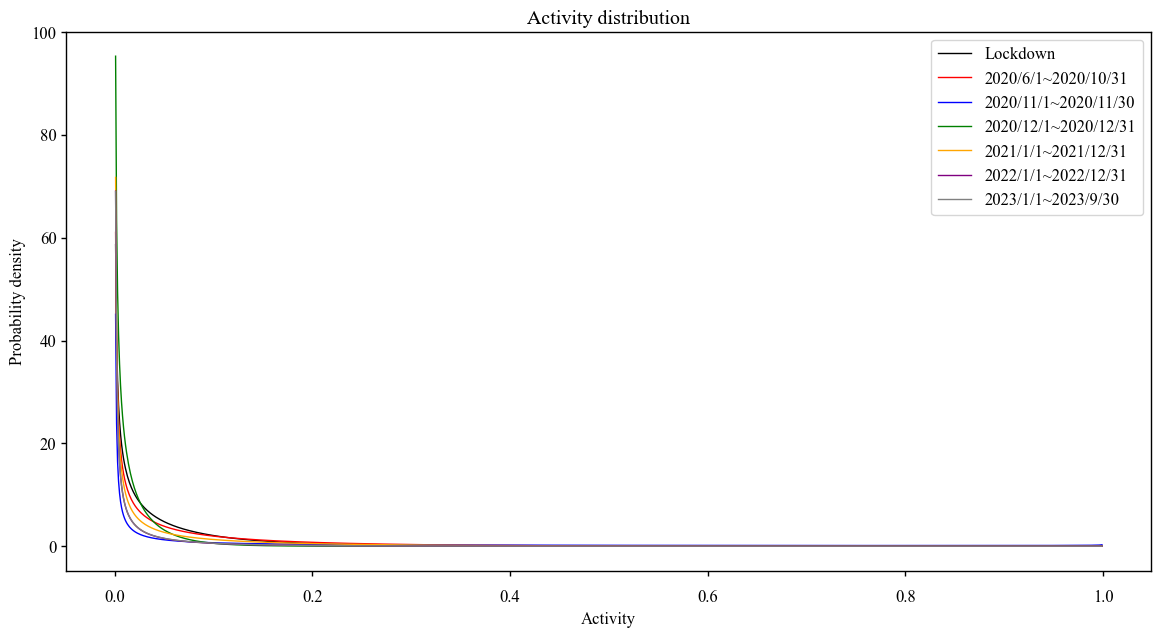

In [57]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(a, stats.beta.pdf(a, alpha_list[0], beta_list[0]), label=label_list[0], color="black", linewidth=1)
plt.plot(a, stats.beta.pdf(a, alpha_list[1], beta_list[1]), label=label_list[1], color="red", linewidth=1)
plt.plot(a, stats.beta.pdf(a, alpha_list[2], beta_list[2]), label=label_list[2], color="blue", linewidth=1)
plt.plot(a, stats.beta.pdf(a, alpha_list[3], beta_list[3]), label=label_list[3], color="green", linewidth=1)
plt.plot(a, stats.beta.pdf(a, alpha_list[4], beta_list[4]), label=label_list[4], color="orange", linewidth=1)
plt.plot(a, stats.beta.pdf(a, alpha_list[5], beta_list[5]), label=label_list[5], color="purple", linewidth=1)
plt.plot(a, stats.beta.pdf(a, alpha_list[6], beta_list[6]), label=label_list[6], color="gray", linewidth=1)

plt.xlabel("Activity")
plt.ylabel("Probability density")
plt.title("Activity distribution")
plt.legend()
plt.show()

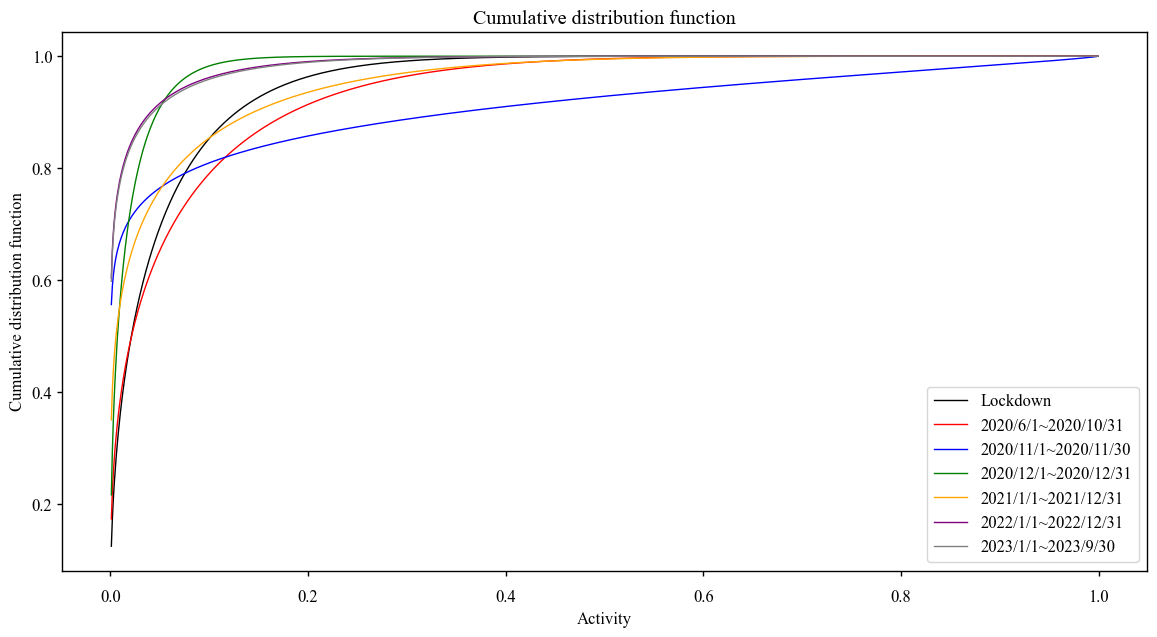

In [56]:
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

a = np.arange(0, 1, 0.001)[1:]
for i in range(len(alpha_list)):
    plt.plot(a, stats.beta.cdf(a, alpha_list[i], beta_list[i]), label=label_list[i], linewidth=1, color=color_list[i])

plt.xlabel("Activity")
plt.ylabel("Cumulative distribution function")
plt.title("Cumulative distribution function")
plt.legend()
plt.show()

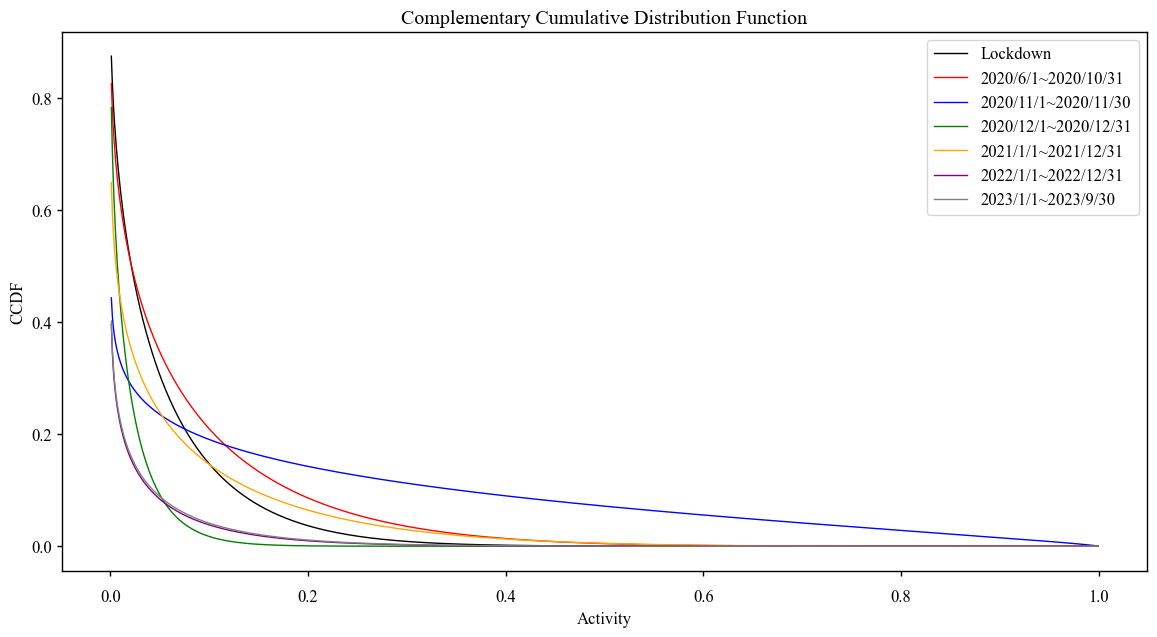

In [59]:
# Completary Cumulative Distribution Function
def ccdf(a, alpha, beta):
    return 1 - special.betainc(alpha, beta, a)

# lockdown時のCCDFを取得
ccdf_lockdown = ccdf(a, alpha_list[0], beta_list[0])[1:]

color_list = ["black", "red", "blue", "green", "orange", "purple", "gray"]

# alpha, betaのリストに対してCCDFを計算
ccdf_list = []
for i in range(len(alpha_list)):
    ccdf_list.append(ccdf(a, alpha_list[i], beta_list[i]))

# lockdown時のCCDFをプロット
fig = plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"


for i in range(len(alpha_list)):
    plt.plot(a, ccdf_list[i], label=label_list[i], linewidth=1, color=color_list[i])

plt.xlabel("Activity")
plt.ylabel("CCDF")
plt.title("Complementary Cumulative Distribution Function")
plt.legend()
plt.show()

In [9]:
# dfを2020年11月と2020年12月に分割
df_2020_11 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-12-01")].dropna()
df_2020_12 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] < "2021-01-01")].dropna()

In [15]:
node_nov, edge_nov, timestamp_nov = return_nm(df_2020_11)

In [16]:
node_dec, edge_dec, timestamp_dec = return_nm(df_2020_12)

11月のノード数:  [489, 510, 538, 540, 535, 557, 566, 564, 542, 523, 504, 518, 509, 494, 446, 505, 498, 506, 531, 525, 507, 467, 501, 414, 441, 468, 508, 509, 486, 440]
12月のノード数:  [465, 480, 490, 491, 500, 473, 467, 476, 494, 503, 456, 426, 483, 480, 463, 454, 455, 482, 469, 473, 487, 479, 480, 380, 288, 419, 446, 462, 430, 388, 426]
11月のエッジ数:  [4904, 6931, 10310, 10422, 10661, 13788, 20717, 16153, 12219, 7777, 7485, 7727, 6823, 6006, 2759, 6108, 5703, 6303, 7895, 8548, 6707, 4264, 5483, 2299, 2741, 3066, 4584, 6277, 4707, 3422]
12月のエッジ数:  [3912, 4789, 4672, 5351, 5277, 3636, 4053, 4075, 5799, 6741, 3336, 2055, 4145, 3807, 4163, 3307, 3510, 4351, 4507, 3761, 4047, 4187, 3921, 1340, 693, 2068, 3057, 3186, 2289, 1584, 2292]


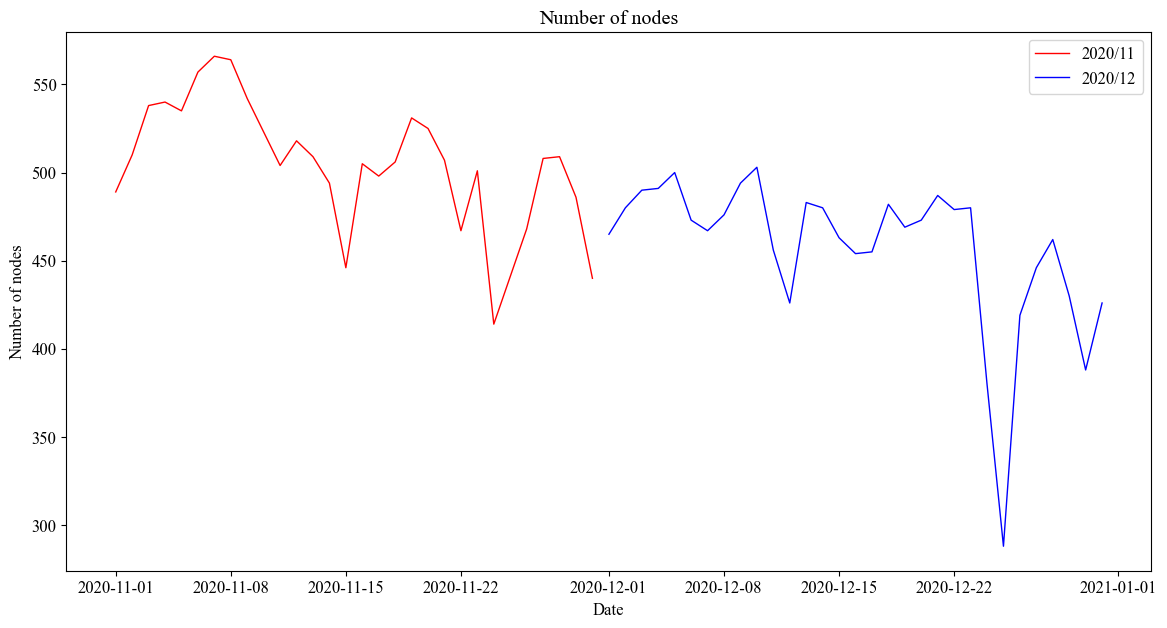

In [17]:
print("11月のノード数: ", node_nov)
print("12月のノード数: ", node_dec)

print("11月のエッジ数: ", edge_nov)
print("12月のエッジ数: ", edge_dec)

# 11月と12月のノード数をプロット
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(timestamp_nov, node_nov, label="2020/11", color="red", linewidth=1)
plt.plot(timestamp_dec, node_dec, label="2020/12", color="blue", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Number of nodes")
plt.title("Number of nodes")
plt.legend()
plt.show()

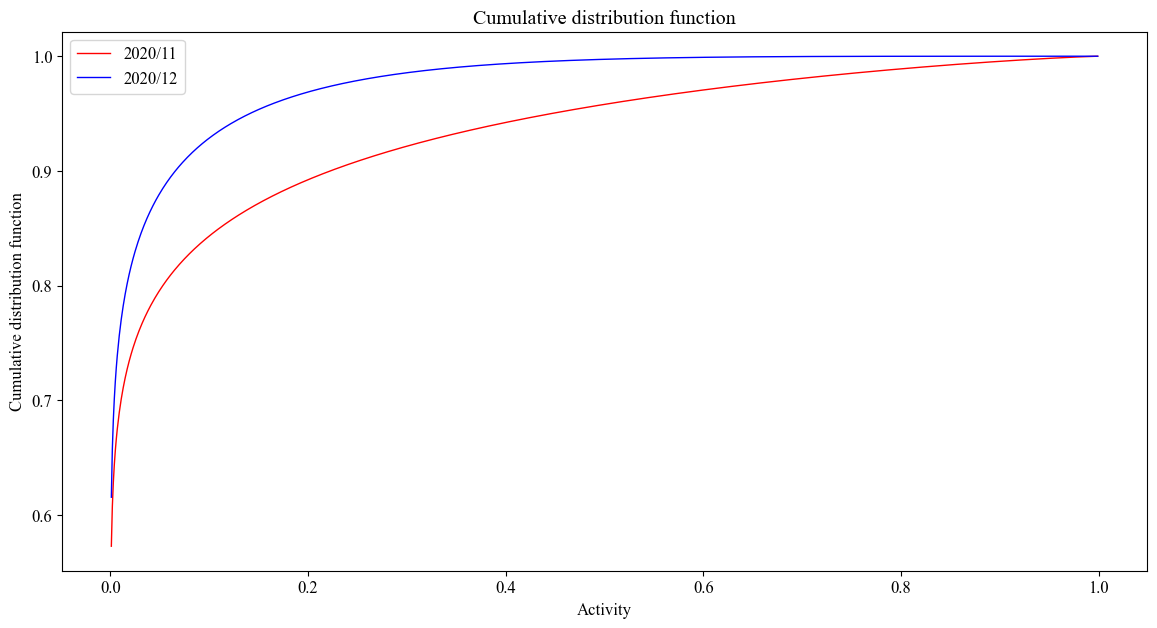

In [23]:
# 11月と12月でCDFをプロット
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"

color_list = ["red", "blue"]
label_list = ["2020/11", "2020/12"]

# novのalpha, betaを求める
Np = 1433
params, _ = optimize.curve_fit(Model3_fixed, edge_nov, node_nov, p0=[1, 1])
alpha_nov = params[0]
beta_nov = params[1]

# decのalpha, betaを求める
Np = 1433
params, _ = optimize.curve_fit(Model3_fixed, edge_dec, node_dec, p0=[1, 1])
alpha_dec = params[0]
beta_dec = params[1]

alpha_list = [alpha_nov, alpha_dec]
beta_list = [beta_nov, beta_dec]

a = np.arange(0, 1, 0.001)[1:]
for i in range(len(alpha_list)):
    plt.plot(a, stats.beta.cdf(a, alpha_list[i], beta_list[i]), label=label_list[i], linewidth=1, color=color_list[i])

plt.xlabel("Activity")
plt.ylabel("Cumulative distribution function")
plt.title("Cumulative distribution function")
plt.legend()
plt.show()

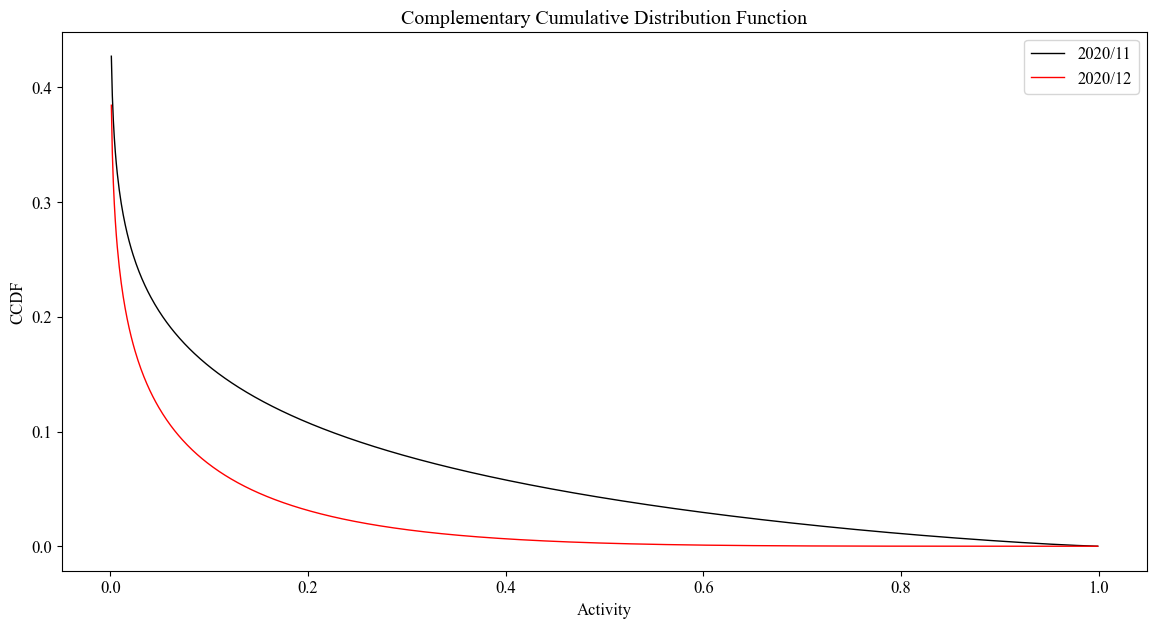

In [24]:
# Completary Cumulative Distribution Function
def ccdf(a, alpha, beta):
    return 1 - special.betainc(alpha, beta, a)

color_list = ["black", "red", "blue", "green", "orange", "purple", "gray"]

# alpha, betaのリストに対してCCDFを計算
ccdf_list = []
for i in range(len(alpha_list)):
    ccdf_list.append(ccdf(a, alpha_list[i], beta_list[i]))

# lockdown時のCCDFをプロット
fig = plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"


for i in range(len(alpha_list)):
    plt.plot(a, ccdf_list[i], label=label_list[i], linewidth=1, color=color_list[i])

plt.xlabel("Activity")
plt.ylabel("CCDF")
plt.title("Complementary Cumulative Distribution Function")
plt.legend()
plt.show()

In [25]:
print("11月のalpha: ", alpha_nov)
print("11月のbeta: ", beta_nov)
print("12月のalpha: ", alpha_dec)
print("12月のbeta: ", beta_dec)

11月のalpha:  0.08436388200239858
11月のbeta:  1.2241510283215882
12月のalpha:  0.0947667119427737
12月のbeta:  4.061374619103253


In [2]:
# ./data/divvy_in_service.csvを読み込み
df_in_service = pd.read_csv("../data/divvy_in_service.csv")
df_in_service = df_in_service.dropna()
df_in_service.head()

,ID,Station Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,1594046383808271024,Troy St & Jackson Blvd,9,9,In Service,41.877505,-87.704850,"(41.877505, -87.70485)"
1,641,Central Park Ave & Bloomingdale Ave,11,11,In Service,41.914166,-87.716755,"(41.914166, -87.716755)"
2,1683527931525155814,Public Rack - Cornell Ave & 87th Pl,1,1,In Service,41.736881,-87.583146,"(41.73688127, -87.58314552)"
3,367,Racine Ave & 35th St,15,15,In Service,41.830689,-87.656211,"(41.83068856472101, -87.65621066093445)"
4,1673852313397164648,Public Rack - Francisco Ave & Touhy Ave,2,2,In Service,42.011865,-87.701317,"(42.011865, -87.701317)"


In [26]:
Np_list = [596, 673, 677, 846, 1431, 1426, 1426]
node_lockdown, edge_lockdown, timestamp_lockdown = return_nm(df_lockdown)
node_resi1, edge_resi1, timestamp_resi1 = return_nm(df_resi1)
node_nov, edge_nov, timestamp_nov = return_nm(df_2020_nov)

df_2020_dec = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()

node_dec, edge_dec, timestamp_dec = return_nm(df_2020_dec)
node_2021, edge_2021, timestamp_2021 = return_nm(df_2021)
node_2022, edge_2022, timestamp_2022 = return_nm(df_2022)
node_2023, edge_2023, timestamp_2023 = return_nm(df_2023)